In [3]:
from quantum_logical.error_channel import AmplitudeDamping, PhaseDamping
import numpy as np
import matplotlib.pyplot as plt
from qutip.metrics import fidelity
from qutip.operators import sigmax, sigmay, sigmaz
from qutip import basis
from qutip import expect
from quantum_logical.error_channel import ErrorChannel
from qutip import Qobj

In [4]:
T1, Tphi = 1, 1
T2 = 1 / (1 / Tphi + 1 / (2 * T1))

In [5]:
zero_rho = basis(2, 0) * basis(2, 0).dag()  # |0><0|
one_rho = basis(2, 1) * basis(2, 1).dag()  # |1><1|
plus_rho = (basis(2, 0) + basis(2, 1)).unit() * (
    basis(2, 0) + basis(2, 1)
).unit().dag()  # |+><+|

In [6]:
def single_qubit_expectations(rho_final):
    """Calculate expectation values of Pauli matrices for a given density matrix."""
    measurements = {"X": sigmax(), "Y": sigmay(), "Z": sigmaz()}
    results = {key: expect(op, rho_final) for key, op in measurements.items()}
    return results


def single_qubit_experiment(rho_initial, delay, trotter_step_size):
    amp_damp_channel = AmplitudeDamping(T1, trotter_step_size)
    phase_damp_channel = PhaseDamping(T2, trotter_step_size)

    # NOTE, we can apply amplitude damping and phase damping in any order
    # because they commute :)

    # Apply the error channel over the entire delay with the given trotter step size
    rho_final = amp_damp_channel.apply_error_channel(rho_initial, delay)
    rho_final = phase_damp_channel.apply_error_channel(rho_final, delay)

    # Calculate expectation values
    expectations = single_qubit_expectations(rho_final)

    # Calculate the fidelity
    fid = fidelity(rho_initial, rho_final)

    return expectations, fid

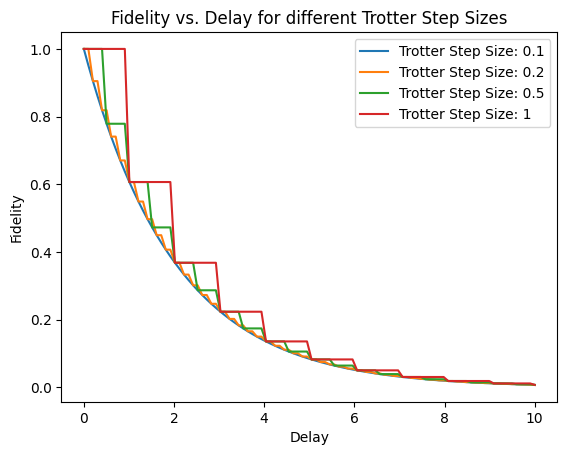

In [7]:
trotter_step_sizes = [0.1, 0.2, 0.5, 1]  # Varying granularities
delays = np.linspace(0, 10, 100)  # Sweeping delay from 0 to 10
initial_state = one_rho

plt.figure()
for step_size in trotter_step_sizes:
    fidelities = [
        single_qubit_experiment(initial_state, delay, step_size)[1] for delay in delays
    ]
    plt.plot(delays, fidelities, label=f"Trotter Step Size: {step_size}")

plt.legend()
plt.xlabel("Delay")
plt.ylabel("Fidelity")
plt.title("Fidelity vs. Delay for different Trotter Step Sizes")
plt.show()

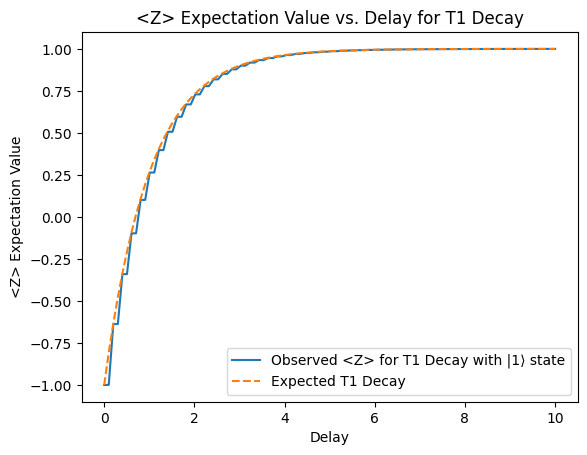

In [8]:
# Expected T1 decay function
def expected_T1_decay(t, T1):
    return 1 - 2 * np.exp(-t / T1)


# Calculate expected values
expected_values_Z_T1 = [expected_T1_decay(delay, T1) for delay in delays]

# For T1 Decay
initial_state_T1 = one_rho  # Assuming this is the |1⟩ state
trotter_step_size = 0.2

results_T1 = [
    single_qubit_experiment(
        initial_state_T1,
        delay,
        trotter_step_size,
    )
    for delay in delays
]

# Extracting expectation values for Z
expectation_values_Z_T1 = [res[0]["Z"] for res in results_T1]

plt.figure()
plt.plot(
    delays,
    expectation_values_Z_T1,
    label="Observed <Z> for T1 Decay with |1⟩ state",
)
plt.plot(delays, expected_values_Z_T1, "--", label="Expected T1 Decay")
plt.legend()
plt.xlabel("Delay")
plt.ylabel("<Z> Expectation Value")
plt.title("<Z> Expectation Value vs. Delay for T1 Decay")
plt.show()

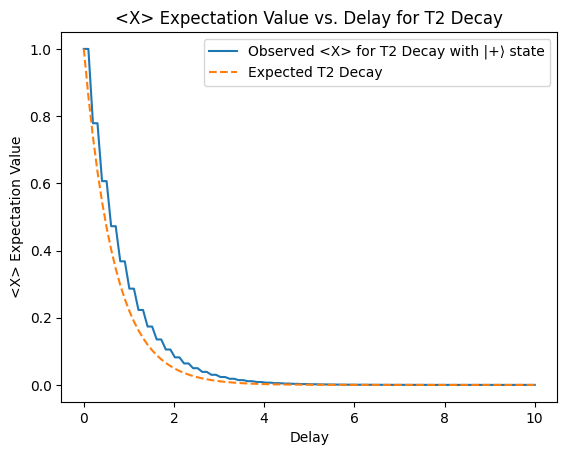

In [9]:
# Expected T2 decay function
def expected_T2_decay(t, T2):
    return np.exp(-t / T2)


# Calculate expected values
expected_values_X_T2 = [expected_T2_decay(delay, T2) for delay in delays]

initial_state_T2 = plus_rho

results_T2 = [
    single_qubit_experiment(
        initial_state_T2,
        delay,
        trotter_step_size,
    )
    for delay in delays
]

# Extracting expectation values for X
expectation_values_X_T2 = [res[0]["X"] for res in results_T2]

plt.figure()
plt.plot(
    delays,
    expectation_values_X_T2,
    label="Observed <X> for T2 Decay with |+⟩ state",
)
plt.plot(delays, expected_values_X_T2, "--", label="Expected T2 Decay")
plt.legend()
plt.xlabel("Delay")
plt.ylabel("<X> Expectation Value")
plt.title("<X> Expectation Value vs. Delay for T2 Decay")
plt.show()

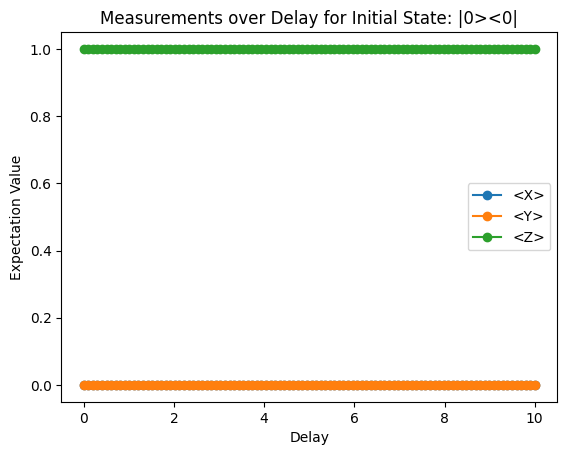

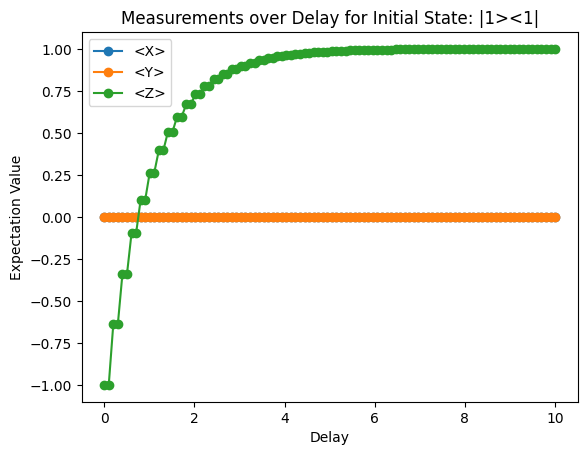

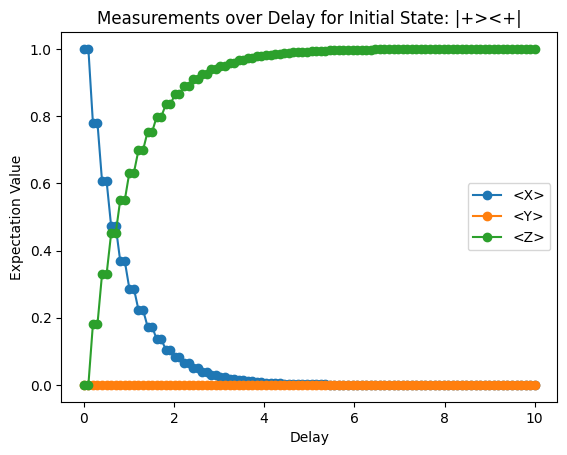

In [10]:
trotter_step_size = 0.2


def plot_qubit_decay_for_initial_state(name, state, T1, T2, delays, trotter_step_size):
    plt.figure()

    results = []
    for delay in delays:
        expectations, _ = single_qubit_experiment(state, delay, trotter_step_size)
        results.append(expectations)

    for key in ["X", "Y", "Z"]:
        values = [res[key] for res in results]
        label_str = f"<{key}>"
        plt.plot(delays, values, "-o", label=label_str)

    plt.xlabel("Delay")
    plt.ylabel("Expectation Value")
    plt.title(f"Measurements over Delay for Initial State: {name}")
    plt.legend()
    plt.show()


initial_states = {"|0><0|": zero_rho, "|1><1|": one_rho, "|+><+|": plus_rho}
for name, state in initial_states.items():
    plot_qubit_decay_for_initial_state(name, state, T1, T2, delays, trotter_step_size)

In [16]:
# test noisy unitary evolution
X_gate = sigmax().full()  # X gate
Z_gate = sigmaz().full()  # Z gate


def single_qubit_experiment(rho_initial, delay, trotter_step_size, unitary=None):
    amp_damp_channel = AmplitudeDamping(T1, trotter_step_size)
    phase_damp_channel = PhaseDamping(T2, trotter_step_size)

    # Combine channels
    combined_channel = ErrorChannel.from_combined_channels(
        [amp_damp_channel, phase_damp_channel], trotter_step_size, 2
    )

    # Initial state
    rho_final = rho_initial

    # expected noiseless evolution
    if unitary is not None:
        rho_expected = Qobj(unitary @ rho_initial.full() @ unitary.conj().T)

    # Apply the error channels over the entire delay with the given trotter step size
    rho_final = combined_channel.apply_error_channel(rho_final, delay, unitary)

    # Calculate expectation values and fidelity
    expectations = single_qubit_expectations(rho_final)
    fid = fidelity(rho_expected, rho_final)

    return expectations, fid

In [17]:
delays = np.linspace(0, 5, 50)  # Sweeping delay from 0 to 10
trotter_step_size = 0.1
initial_state = zero_rho  # Or choose another initial state

# Prepare data storage
expectations_over_time_x = {"X": [], "Y": [], "Z": []}
expectations_over_time_z = {"X": [], "Y": [], "Z": []}

# Prepare data storage for fidelities
fidelities_x = []
fidelities_z = []

# Run experiments
for delay in delays:
    # X gate followed by noise
    exp_values_x, fidelity_x = single_qubit_experiment(
        initial_state, delay, trotter_step_size, unitary=X_gate
    )
    for key in exp_values_x:
        expectations_over_time_x[key].append(exp_values_x[key])

    fidelities_x.append(fidelity_x)

    # Z gate followed by noise
    exp_values_z, fidelity_z = single_qubit_experiment(
        initial_state, delay, trotter_step_size, unitary=Z_gate
    )
    for key in exp_values_z:
        expectations_over_time_z[key].append(exp_values_z[key])
    fidelities_z.append(fidelity_z)

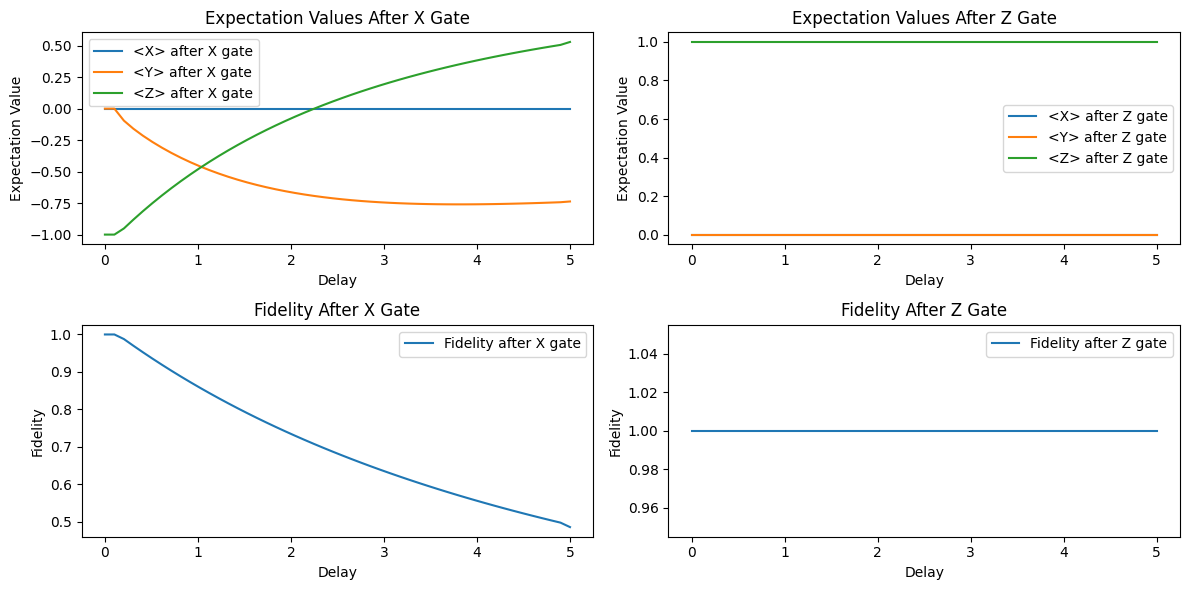

In [18]:
plt.figure(figsize=(12, 6))

# Expectation values for X gate
plt.subplot(2, 2, 1)
for key in ["X", "Y", "Z"]:
    plt.plot(delays, expectations_over_time_x[key], label=f"<{key}> after X gate")
plt.xlabel("Delay")
plt.ylabel("Expectation Value")
plt.title("Expectation Values After X Gate")
plt.legend()

# Expectation values for Z gate
plt.subplot(2, 2, 2)
for key in ["X", "Y", "Z"]:
    plt.plot(delays, expectations_over_time_z[key], label=f"<{key}> after Z gate")
plt.xlabel("Delay")
plt.ylabel("Expectation Value")
plt.title("Expectation Values After Z Gate")
plt.legend()

# Fidelity for X gate
plt.subplot(2, 2, 3)
plt.plot(delays, fidelities_x, label="Fidelity after X gate")
plt.xlabel("Delay")
plt.ylabel("Fidelity")
plt.title("Fidelity After X Gate")
plt.legend()

# Fidelity for Z gate
plt.subplot(2, 2, 4)
plt.plot(delays, fidelities_z, label="Fidelity after Z gate")
plt.xlabel("Delay")
plt.ylabel("Fidelity")
plt.title("Fidelity After Z Gate")
plt.legend()

plt.tight_layout()
plt.show()